# Timeseries Similarity Search for ROS Data
**Context**

This notebook demonstrates how to leverage the [robologs-ros-utils](https://github.com/roboto-ai/robologs-ros-utils) and [robologs-timeseries-utils](https://github.com/roboto-ai/robologs-timeseries-utils) open-source packages to perform a multi-signal timeseries similarity search in a rosbag.
 
**Goal**

Find the most similar looking subsequences for a query signal in a given IMU signal. 

**Steps**
- Extract IMU and image data from a rosbag using [robologs-ros-utils](https://github.com/roboto-ai/robologs-ros-utils)
- Plot IMU angular velocities (angular_velocity.x, angular_velocity.y, angular_velocity.z)
- Select a region of interest in the IMU plot as a query signal, show corresponding video sequence
- Search for the n-most similar subsequences in the IMU plot
- Visualize the n-most similar subsequences against the query signal
- Show video of n-most similar subsequences

**Data**

The drone racing dataset used in this notebook was recorded by the Robotics and Perception Group (RPG) at the University at Zurich and can be found [here](https://fpv.ifi.uzh.ch/datasets/). It is released under the [Creative Commons license (CC BY-NC-SA 3.0)](https://creativecommons.org/licenses/by-nc-sa/3.0/), which is free for non-commercial use (including research).

# Parameters for configuring the notebook

In [1]:
import os
INPUT_DIR = os.path.expanduser("~/sim_search_example/")
OUTPUT_DIR = os.path.expanduser("~/sim_search_example/output/")
ROSBAG_NAME = "indoor_forward_3_snapdragon_with_gt.bag"
DOWNLOAD_PATH_TEMPLATE = "http://rpg.ifi.uzh.ch/datasets/uzh-fpv-newer-versions/v3/{}"
IMG_TOPIC_NAME = "/snappy_cam/stereo_l"
IMU_TOPIC_NAME = "/snappy_imu"
GROUNDTRUTH_TOPIC_NAME = "/groundtruth/pose"
OUTPUT_IMU_CSV = "snappy_imu.csv"
OUTPUT_GROUNDTRUTH_CSV = "groundtruth-pose.csv"
IMG_FOLDER_NAME = "snappy_cam_stereo_l/"
IMG_FOLDER_PATH = os.path.join(OUTPUT_DIR, IMG_FOLDER_NAME)
TOPIC_FREQ = 500
N_SIMILAR_SEQUENCES = 5

# Cell 1: Install Required Packages
This cell is for installing the necessary packages required to run the rest of the notebook. 
The packages include robologs-ros-utils, stumpy, opencv-python, numpy, plotly, and dash.

In [2]:
%%capture
# List of packages to be installed
PACKAGES = [
    "robologs-ros-utils",
    "stumpy",
    "opencv-python",
    "numpy==1.23.1",
    "plotly",
    "dash"
]

# Run pip install for each package
for package in PACKAGES:
    !pip install {package}

# Filter out warnings
import warnings
warnings.filterwarnings("ignore")

print("Setup complete.")

# Cell 2: Import Required Libraries
In this cell, we import all the necessary libraries that we are going to use throughout the notebook.

In [3]:
import shutil
from robologs_ros_utils.sources.ros1 import ros_utils
import sys
import pandas as pd
import json
from IPython.display import Video
import sys
sys.path.insert(0, '../utils/')
import ts_utils

# Cell 3: Define and Run Helper Functions
This cell contains helper functions that encapsulate the specific tasks needed in the notebook.

In [4]:
def prepare_directories(input_dir, output_dir):
    """
    Prepare the input and output directories by creating them if they do not exist,
    and clean up the output directory if it already exists.
    """

    # Clean up output folder
    if os.path.exists(output_dir):
        # Delete the folder
        shutil.rmtree(output_dir)
        
    os.makedirs(input_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)

def download_data(input_dir, rosbag_names, download_path_template):
    """
    Download the rosbag data files into the input directory.
    """

    for rosbag_name in rosbag_names:
        download_path = download_path_template.format(rosbag_name)
        file_path = os.path.join(input_dir, rosbag_name)
        print(file_path)
        if not os.path.exists(file_path):
            print(f"Downloading {rosbag_name} to {input_dir}")
            !wget -q --show-progress -O {file_path} {download_path}
        else:
            print(f"File {rosbag_name} already exists in {input_dir}")

def extract_data(input_dir, output_dir, rosbag_name, img_topic_name, imu_topic_name, groundtruth_topic_name, output_imu_csv, output_groundtruth_csv, img_folder_name):
    """
    Extract images and IMU timeseries data from the rosbag data files.
    """

    rosbag_path = os.path.join(input_dir, rosbag_name)
    
    # Extract images
    ros_utils.get_images_from_bag(
    rosbag_path=rosbag_path,
    output_folder=output_dir,
    create_manifest=True,
    topics=[img_topic_name],
    naming="rosbag_timestamp")

    # Extract topic data
    ros_utils.get_csv_data_from_bag(
        input_dir_or_file=rosbag_path, 
        output_dir=output_dir, 
        topic_list=[imu_topic_name, groundtruth_topic_name])
    
def prepare_data(output_dir, output_folder_name, output_imu_csv, output_groundtruth_csv, img_folder_path, ff):
    """
    Load data from CSV files, preprocess the ground truth data,
    and get the image manifest.
    """

    # Construct file paths
    filepath_imu = os.path.join(output_dir, f"{output_folder_name}/{output_imu_csv}")
    filepath_groundtruth = os.path.join(output_dir, f"{output_folder_name}/{output_groundtruth_csv}")

    # Load data
    df = pd.read_csv(filepath_imu)
    first_timestamp = df["Time"].iloc[0]
    img_manifest = json.load(open(img_folder_path + "img_manifest.json"))

    # Preprocess ground truth
    gt_df = ts_utils.preprocess_ground_truth(filepath_groundtruth, first_timestamp, (ff, ff))

    return df, img_manifest, gt_df,filepath_imu, filepath_groundtruth

    
prepare_directories(input_dir=INPUT_DIR,
                    output_dir=OUTPUT_DIR)

download_data(input_dir=INPUT_DIR,
              rosbag_names=[ROSBAG_NAME],
              download_path_template=DOWNLOAD_PATH_TEMPLATE)

extract_data(input_dir=INPUT_DIR, 
             output_dir=OUTPUT_DIR, 
             rosbag_name=ROSBAG_NAME, 
             img_topic_name=IMG_TOPIC_NAME, 
             imu_topic_name=IMU_TOPIC_NAME, 
             groundtruth_topic_name=GROUNDTRUTH_TOPIC_NAME, 
             output_imu_csv=OUTPUT_IMU_CSV, 
             output_groundtruth_csv=OUTPUT_GROUNDTRUTH_CSV, 
             img_folder_name=IMG_FOLDER_NAME)

output_folder_name = ROSBAG_NAME.split(".")[0]


df, img_manifest, gt_df, filepath_imu, filepath_groundtruth = prepare_data(
    output_dir=OUTPUT_DIR, 
    output_folder_name=output_folder_name, 
    output_imu_csv=OUTPUT_IMU_CSV, 
    output_groundtruth_csv=OUTPUT_GROUNDTRUTH_CSV, 
    img_folder_path=IMG_FOLDER_PATH,
    ff=TOPIC_FREQ)

/home/yves/sim_search_example/indoor_forward_3_snapdragon_with_gt.bag
File indoor_forward_3_snapdragon_with_gt.bag already exists in /home/yves/sim_search_example/
[INFO]  Data folder /home/yves/sim_search_example/indoor_forward_3_snapdragon_with_gt already exists. Not creating.
Robologs: iterating over 2552 images to extract: 2552 images


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2552/2552 [00:10<00:00, 252.68it/s]


[INFO]  Data folder /home/yves/sim_search_example/indoor_forward_3_snapdragon_with_gt already exists. Not creating.
[INFO]  Data folder /home/yves/sim_search_example/indoor_forward_3_snapdragon_with_gt already exists. Not creating.


# Cell 4: Interactive Plot for Similarity Search
This cell defines a function to create an interactive plot for the similarity search.
The function makes use of the `create_interactive_plot` function from the `ts_utils` module
to create a plotly plot for time series data. The interactive plot allows the user to select 
regions of the data to compare for similarity.

In [5]:
def interactive_similarity_search(filepath_imu, topic_names):
    """
    Create an interactive plot for the similarity search.
    """

    # Create interactive plot
    app, selected_indices = ts_utils.create_interactive_plot(filepath_imu, topic_names)
    return app, selected_indices

# Run interactive similarity search
TOPIC_NAMES = ["angular_velocity.x", "angular_velocity.y", "angular_velocity.z"]
app, selected_indices = interactive_similarity_search(filepath_imu, 
                                                      topic_names=TOPIC_NAMES)

# Cell 5: Show Query Video
This cell creates a query video based on a given time range.
The `show_imgs_based_on_timerange_video` function is utilized from the `ts_utils` module.

In [6]:
# Create query video
try:
    start_index_q = selected_indices[0]
    end_index_q = selected_indices[1]
except Exception as e:
    print(f"Please select a region of the above plot: {e}")
    
# Create video
video_path = ts_utils.show_video_based_on_timerange(start_index_q/TOPIC_FREQ, 
                                                    end_index_q/TOPIC_FREQ, 
                                                    IMG_FOLDER_PATH, 
                                                    gt_df, 
                                                    img_manifest, 
                                                    OUTPUT_DIR)

# Display the WebM video in the notebook
Video(video_path, embed=True, width=1000)

# Cell 6: Find Similar Subsequences
This cell defines a function to find similar subsequences in the data.
The function makes use of the `get_similar_intervals_multi` function from the `ts_utils` module
to perform this task.

In [7]:
def find_similar_subsequences(df, start_index_q, end_index_q, topic_names, n=5):
    """
    Find similar subsequences in the data.
    """

    # Get query subsequences
    queries = [df.loc[start_index_q:end_index_q, topic_name] for topic_name in topic_names]
    
    # Get most similar sequences for each topic
    results, interval_list = ts_utils.get_similar_intervals_multi(filepath_imu, start_index_q, end_index_q, topic_names, n)
    
    return queries, results, interval_list

# Find similar subsequences
queries, results, interval_list = find_similar_subsequences(df, start_index_q, end_index_q, TOPIC_NAMES)

# Cell 7: Compare Signals
This cell compares the original query sequence with the most similar subsequences found in the previous cell.
Two different comparison views are provided: the subsequences plotted on the full data, and each subsequence
plotted separately for comparison.

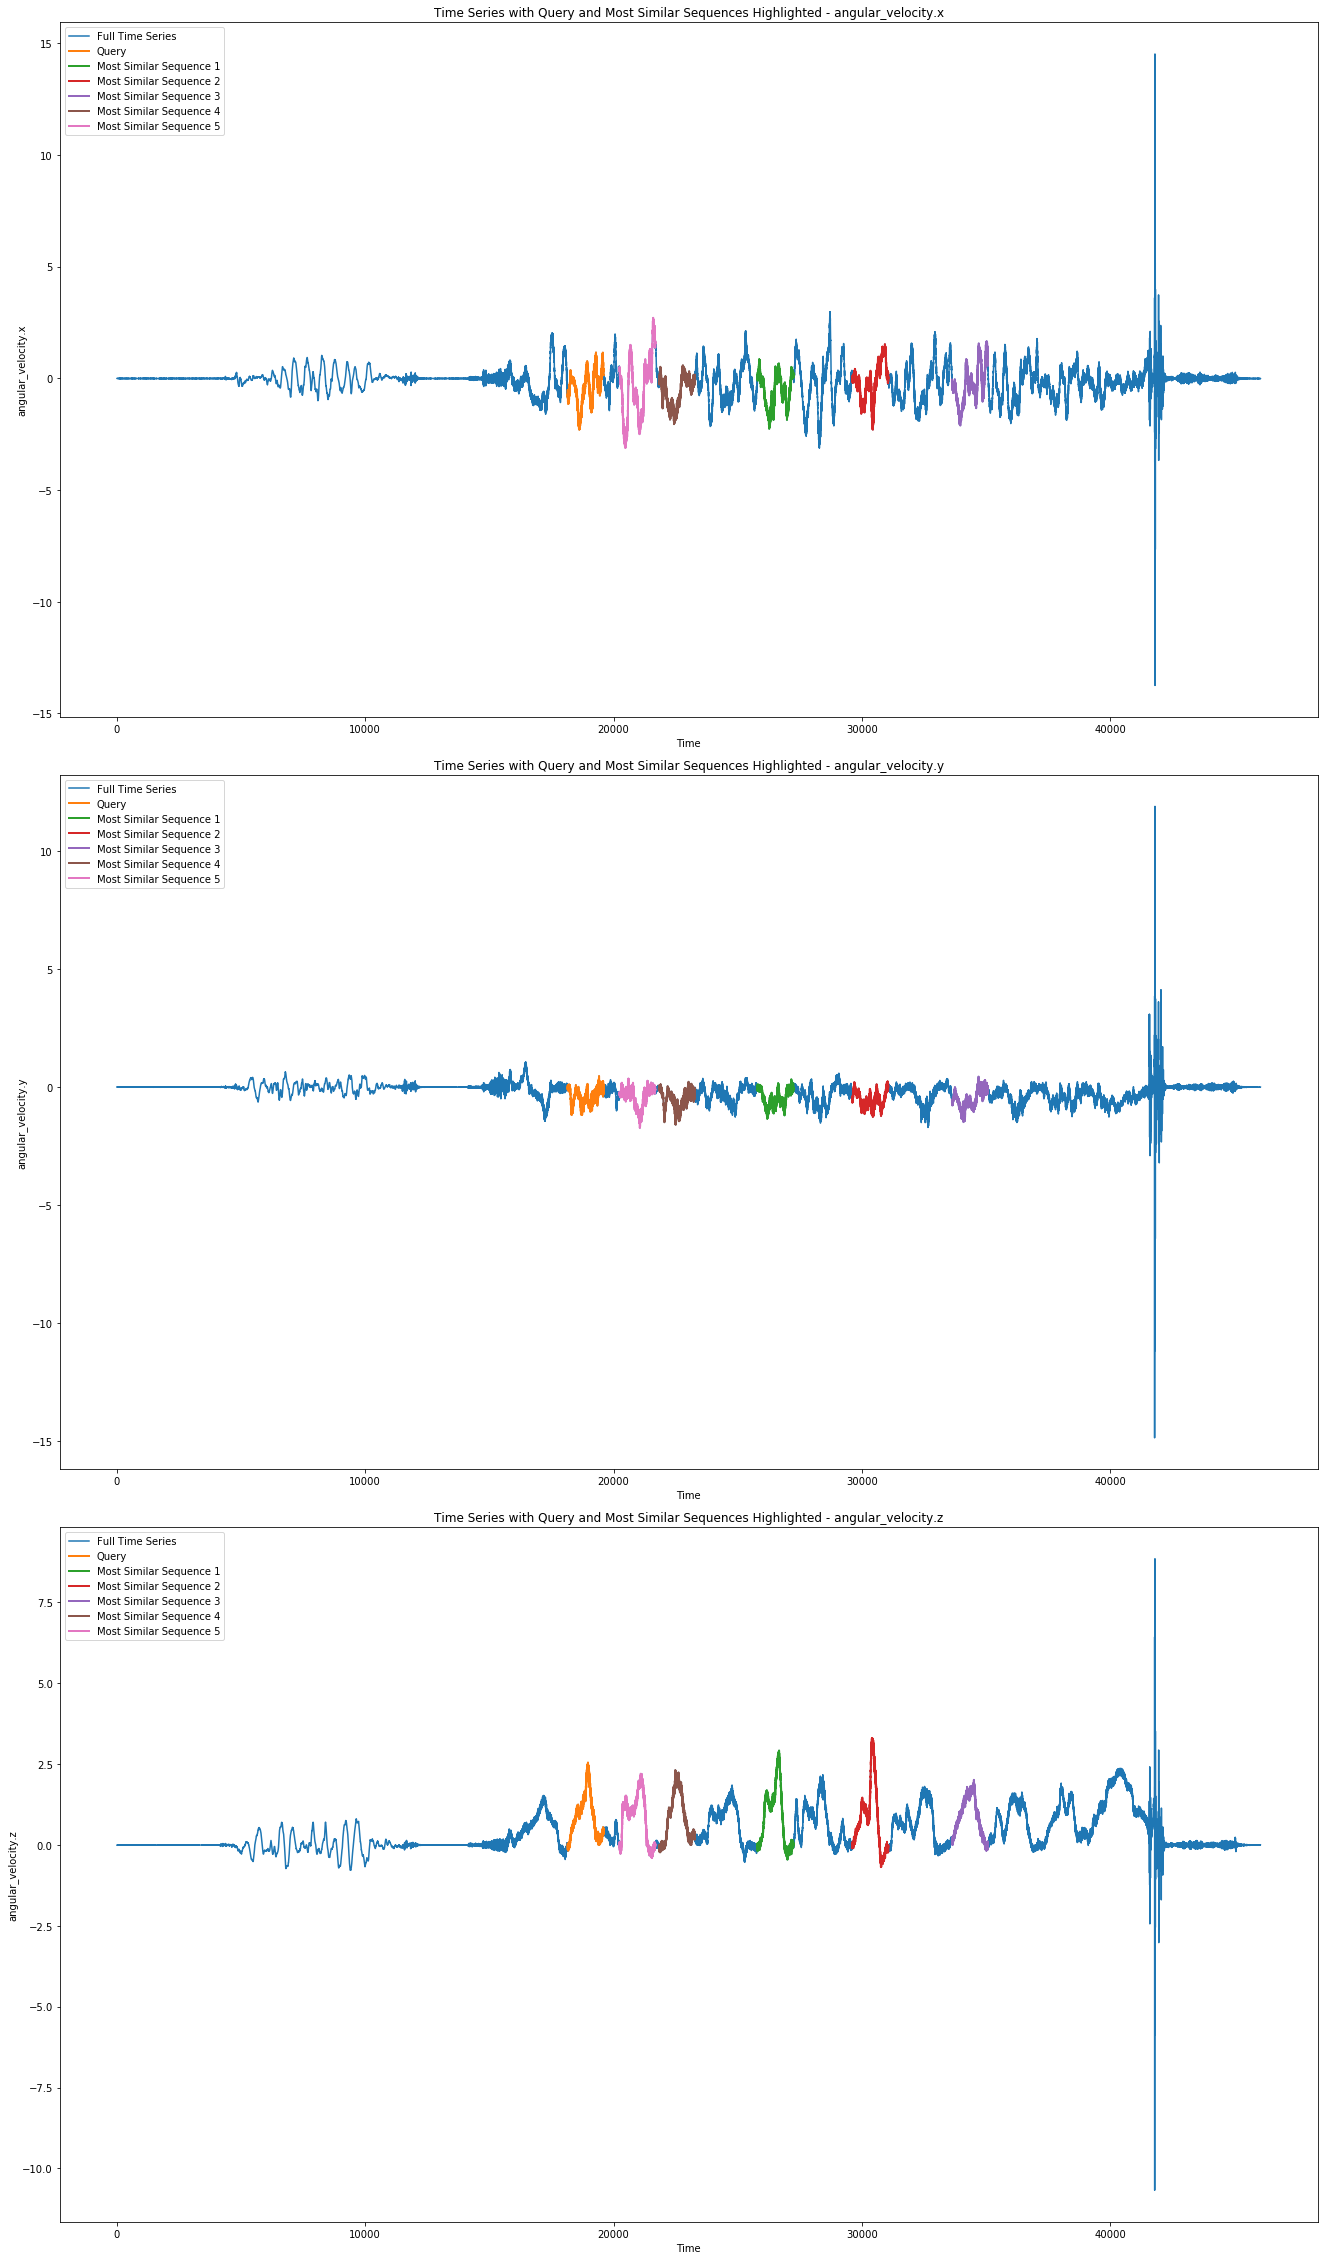

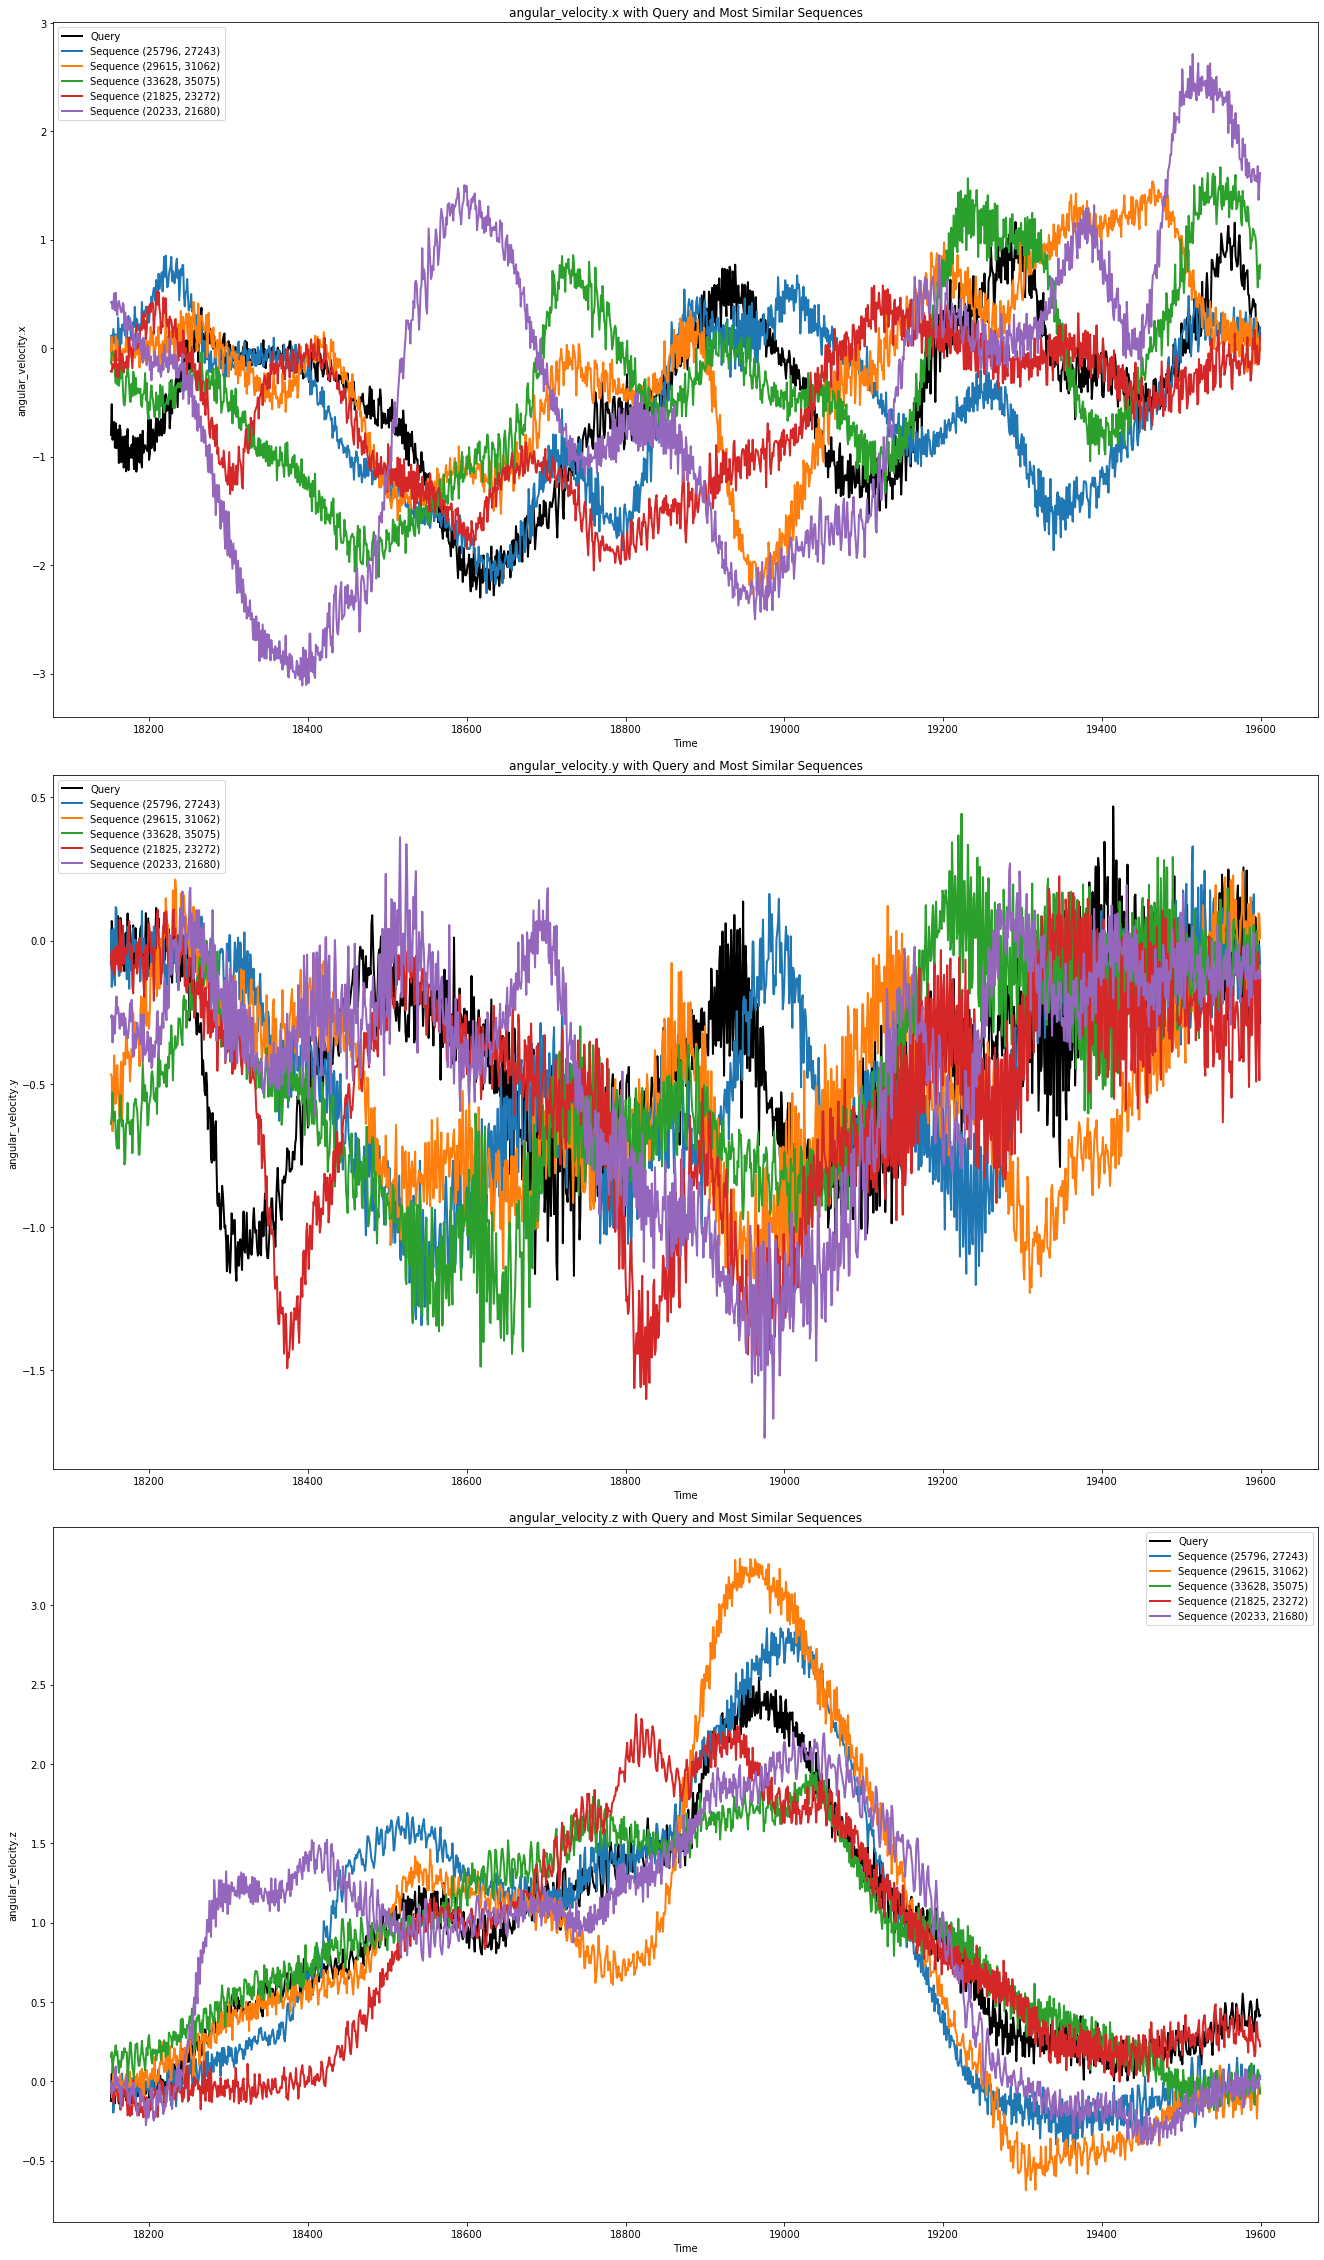

In [8]:
def compare_signals(df, queries, results, topic_names, interval_list):
    """
    Compare the original query sequence with the most similar subsequences.
    """
    
    # Plot the subsequences on the full data
    ts_utils.plot_sequence_on_full_data_multi(df, queries, results, topic_names)
    
    # Plot each subsequence separately for comparison
    ts_utils.plot_query_and_results_multi(queries, results, topic_names, interval_list)


# Compare signals
compare_signals(df, queries, results, TOPIC_NAMES, interval_list)

# Cell 8: Show videos of similar subsequences
This cell shows the videos of the query subsequence and the most similar subsequences found.
It does this by first calling the `show_imgs_based_on_timerange_video` function from the `ts_utils` module
for each subsequence, and then displaying the created video using IPython's Video function.

In [9]:
def show_videos_of_similar_subsequences(interval_list, img_folder_path, gt_df, img_manifest, output_dir):
    """
    Show the videos of the query subsequence and the most similar subsequences found.
    """
    for i, interval in enumerate(interval_list):
        print(f"Showing video for sequence {i+1}")
        start_index = interval[0]
        end_index = interval[1]
        video_path = ts_utils.show_video_based_on_timerange(start_index/TOPIC_FREQ, 
                                                                 end_index/TOPIC_FREQ, 
                                                                 img_folder_path, 
                                                                 gt_df, 
                                                                 img_manifest, 
                                                                 output_dir)
        
        # Display the created video
        display(Video(video_path, embed=True, width=1000))


# Show videos of similar subsequences
show_videos_of_similar_subsequences(interval_list, IMG_FOLDER_PATH, gt_df, img_manifest, OUTPUT_DIR)


Showing video for sequence 1


Showing video for sequence 2


Showing video for sequence 3


Showing video for sequence 4


Showing video for sequence 5


# Cell 10: Clear Temporary Data
This cell removes temporary files and folders generated during the notebook's execution.
It does this by calling the `shutil.rmtree` function for each directory to be removed.
The directories to be removed can be specified when calling the `clear_temp_data` function.
If no directories are specified, the default directories in the `dirs_to_remove` list are removed.

In [17]:
def clear_temp_data(dirs_to_remove=None):
    """
    Removes specified directories.
    """
    if dirs_to_remove is None:
        # Default directories to remove
        dirs_to_remove = [OUTPUT_DIR]
    
    # Remove each directory
    for dir in dirs_to_remove:
        if os.path.exists(dir):
            shutil.rmtree(dir)
            print(f"Removed: {dir}")
        else:
            print(f"{dir} does not exist")

# Remove temporary data
clear_temp_data()

Removed: /home/yves/sim_search_example/output/
